### Student Name

This aim of this course is to review the evolution of image processing tools from hand-crafted methods to deep learning algorithms. The semester is split into four labs :

* **Lab 1** : Introduction to Image Processing Using Hand-Crafted Features
* **Lab 2** : Object detection
* **Lab 3** : Object tracking
* **Lab 4** : Introduction to Deep Learning for image classification and generative model

Let's start with the third chapter of this course!

# Chapter 3 : Object Tracking 
(100 pts)

In [72]:
import cv2 as cv
import numpy as np
import os
import math
import tarfile
import time as _time
from utils import *
import matplotlib.pyplot as plt
%matplotlib inline


## 1 Video Processing and Detection. 

In this first part of chapter 3, you will be asked to construct a series of functions tools to handle video processing and basic detection. You will use the same HOG+SVM classifier from Chapter 2 and adapt it to handle video input.

In contrast to the previous assignments, we will not provide a guided skeleton of the function. You will use any high level (already implemented) function from OpenCV to complete the exercise specifications and outputs. In addition, you will be asked to search in the documentation (or your favourite reference) the specific usage of the functions. 

__Section Objectives:__

* Construct a Video processing pipeline.
* Use OpenCV functions on the video frames for human detection.
* Analyse and compare tracking methodes proposed by OpenCV

__Data__:

The folder ``../data/videos`` contains three sample videos to test your functions.


### 1.1 Reading/Writing video (5 pts)

A video file can be abstracted as a bunch of images of the same dimensions in order (*i.e. collection*). 

**QUESTION**

Your first task is to complete the function `transform_video_file(...)` which will operate on every frames of a given video file. The following steps are required:

- Open video file with OpenCV
- Iterate overall frames or a subset of them (based on `n_frame` parameter)
- Apply the processing function. The function's signature needs to be `function(np.array, Any) -> Any`

To read videos you can use the OpenCV build-in functions, namely `cv::VideoCapture` class. More informations is available in the [docs](https://docs.opencv.org/3.4.4/d8/dfe/classcv_1_1VideoCapture.html#a473055e77dd7faa4d26d686226b292c1).


In [73]:
def transform_video_file(file_path, function, params=None, n_frame=-1):
    """
    Given the path of a video file (file_path) the function reads every frame of the input video and applies a given
    transformation (function) using the parameters (params)

    :input_image:       Input video file path 
    :function:          Function be applied to each frame of the image. Signature `function(np.array, Any) -> Any`
    :params:            Any parameter needed for the function above.
    :n_frame:           Maxiumum number of frame to read. Default `-1`, read all the content
    :return:            output_handler this can be anything you may need to save your results.
    """
    output_handler = []
    # Open video
    cap = cv.VideoCapture(file_path)
    if cap.isOpened():
        
        #######################
        # YOUR CODE HERE
        while True:
            ret, frame = cap.read()
            if ret == False:
                break
            frame_processed = function(frame, params)
            output_handler.append(frame_processed)
            if n_frame > 0 and len(output_handler) >= n_frame:
                break

        #######################

        pass
                
    else:
        raise ValueError('Can not open file: {}'.format(file_path))
    # Close reader
    cap.release()
    # Return custom structure
    return output_handler

### 1.2 Example

The example below shows how the `transform_video_file` can be used. It will open the video named `speaker.avi` and process only the first **2** frames.

In [74]:
# Example of usage:
def dummy_function(image, params):
    if('dummy_function' in params[0]):
        print('Func: "{}", Message "{}", File: "{}"'.format(params[0], params[1], params[2]))
        print('Image dims: {}'.format(image.shape))
    return 'I did it'
    
# Define parameters
file_name = '../data/videos/speaker.avi'
extra_params = ['dummy_function', 'Hello from the video file', file_name];

# Process single frame
transform_video_file(file_path=file_name, function=dummy_function, params=extra_params, n_frame=2)

Func: "dummy_function", Message "Hello from the video file", File: "../data/videos/speaker.avi"
Image dims: (720, 1280, 3)
Func: "dummy_function", Message "Hello from the video file", File: "../data/videos/speaker.avi"
Image dims: (720, 1280, 3)


['I did it', 'I did it']

### 1.3 Testing your function (5 pts)

To test your function you need to process the video: ``../data/videos/video_gym.avi``. 

**QUESTION**

At each frame, you will count the number of __green__ pixels. At the end you should return two outputs:

* The __frame number__ with the maximum number of green pixels
* The __image__ frame with more green pixels. You are asked to display the original frame with the green pixels **replaced** by their grayscale value.

Display the image and the frame number. 



Max number of green pixels:9459 at frame 733


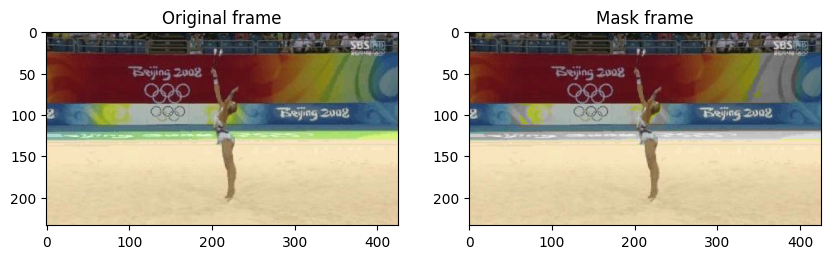

In [75]:
# Frame processing function
def processing_fn(image, params):
    """
    Count the number of colored pixels in a given image. This function also extracts the region where the pixels are green
    in form of a mask.
    
    :param image:  Frame to analyse
    :param params: Extra parameters that my be required by the functions
    """
    nb_green_pix = 0 
    mask    = None
    #######################
    # YOUR CODE HERE
    hsv = cv.cvtColor(image, cv.COLOR_BGR2HSV)
    th_high = params['th_high']
    th_low = params['th_low']
    # Create mask
    mask = cv.inRange(hsv, th_low, th_high)
    nb_green_pix = cv.countNonZero(mask)
    ######################
    
    # Done
    return (nb_green_pix, mask) # Magic structure with the number of green pixels + mask


# Video file
file_path   =  os.path.join('..','data', 'videos', 'video_gym.avi')

# Find and display frame with max number of green pixels
    
#################################
# YOUR CODE HERE
original_output = transform_video_file(file_path=file_path, function=lambda x, y: x, params=None, n_frame=-1)

# Define a range of green colors
light_green = np.array([35,  40,  40])
dark_green  = np.array([85, 255, 255])
params = {'th_low': light_green, 'th_high': dark_green}

# Process the video
output_handler = transform_video_file(file_path=file_path, function=processing_fn, params=params, n_frame=-1)

# Get the maximum number of green pixels
max_green = max(output_handler, key=lambda x: x[0])[0]
mask = max(output_handler, key=lambda x: x[0])[1]
max_index = output_handler.index(max(output_handler, key=lambda x: x[0]))
print(f'Max number of green pixels:{max_green} at frame {max_index}')

# Mask the original frame
img_gray = cv.cvtColor(original_output[max_index], cv.COLOR_BGR2GRAY)
img_gray_3ch = cv.cvtColor(img_gray, cv.COLOR_GRAY2BGR)
img_masked = original_output[max_index].copy()
img_masked[mask == 255] = img_gray_3ch[mask == 255]

# Display frame
plt.figure(figsize=(10, 10))
plt.subplot(1, 2, 1)
plt.imshow(cv.cvtColor(original_output[max_index],cv.COLOR_BGR2RGB))
plt.title('Original frame')

plt.subplot(1, 2, 2)
plt.imshow(cv.cvtColor(img_masked, cv.COLOR_BGR2RGB))
plt.title('Mask frame')
plt.show()
#################################



**QUESTION**

Secondly, at each 30 seconds of the video, show the following results

- Extracted mask
- Number of green pixels counted


Frame 0, number of green pixels: 8074


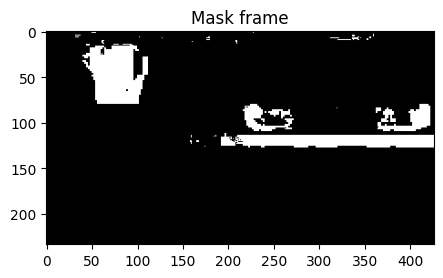

Frame 450, number of green pixels: 7971


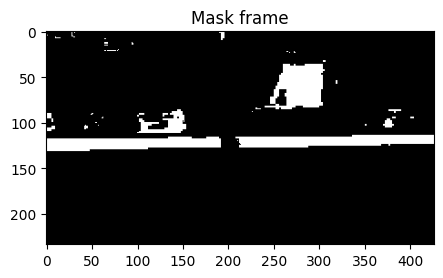

In [81]:
#################################

# YOUR CODE HERE
TIME_INTERVAL = 30 # s
# get fps 
video = cv.VideoCapture(file_path)
fps = video.get(cv.CAP_PROP_FPS)

for i in range(0, len(output_handler), int(fps*TIME_INTERVAL)):
    print(f'Frame {i}, number of green pixels: {output_handler[i][0]}')
    plt.figure(figsize=(5, 5))
    plt.imshow(output_handler[i][1], cmap='gray')
    plt.title('Mask frame')
    plt.show()

#################################


### 1.4 The return of the HOG. (5 pts)

Do you remember HOG? Here is a small reminder how to use it.

Image has dimensions: (480, 640, 3)


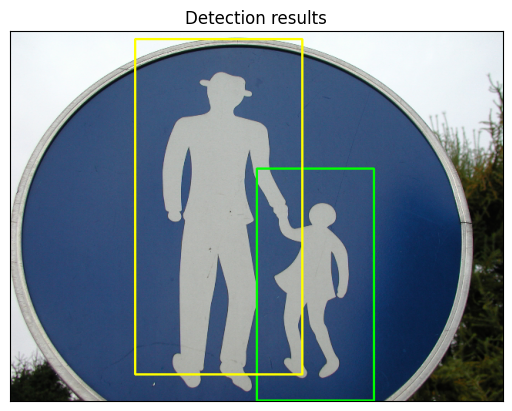

In [83]:
# initialize the HOG descriptor/person detector
hog = cv.HOGDescriptor()
hog.setSVMDetector(cv2.HOGDescriptor_getDefaultPeopleDetector())

# load base image (check that we are not scaling, normalizing or changing the channels)
img = cv.imread(os.path.join('..','data', 'person_454.bmp'))
print('Image has dimensions: {}'.format(img.shape))

# The HOG detector returns an array with the Regions of maximum likehood to contain a human-shaped-form
rects, weights = hog.detectMultiScale(img , winStride=(4, 4), padding=(8, 8), scale=1.05)

# draw the original bounding boxes
persons = 0;
for k, (x, y, w, h) in enumerate(rects):
    cv2.rectangle(img , (x, y), (x + w - 1, y + h -1), (0, 255, k * 256), 2)
    
display_image(img);
plt.title('Detection results')
plt.xticks([])
plt.yticks([]);

Finally, you will glue together your brand new image processing function and the HOG descriptor from OpenCV above. You are asked to write a function `detection_fn` to perform person detection, and test your implementation.

### Testing your function

To test your function you need to process the video: ``../data/videos/video_skater.avi``.

**QUESTION**

 At each frame, you will use HOG to detect any person in the frame. Your function should return: 

* The image __frame__ corresponding to __the seconds 1, 2, ... , 10__ of the video with the rectangle showing the "detected area" if any. 


__Be sure to display all the 10 frames for grading__


In [89]:
# 1. Write detection_fn

def detection_fn(detector, image, params):
    """
    Run pedestrian detector on a given image.
    
    :param detector: HOG Detector instance
    :param image: Image to process
    :param params: Extra parameters needed by the function
    :return: Detected pedestrian bounding boxes
    """
    
    box     = None
    frame   = None
    
    ########################
    # YOUR CODE HERE
    frame = image.copy()
    rects, weights = detector.detectMultiScale(image , winStride=(4, 4), padding=(8, 8), scale=1.05)
    # draw the original bounding boxes
    persons = 0;
    for k, (x, y, w, h) in enumerate(rects):
        cv2.rectangle(frame , (x, y), (x + w - 1, y + h -1), (0, 255, k * 256), 2)
        persons += 1
    ########################
    return frame, box
    
#2. Test the implementation
# Video file
file_path   =  os.path.join('..','data', 'videos', 'video_skater.avi')
outputs     = transform_video_file(file_path, lambda im, p: detection_fn(hog, im, p), n_frame=350);


Frame 0


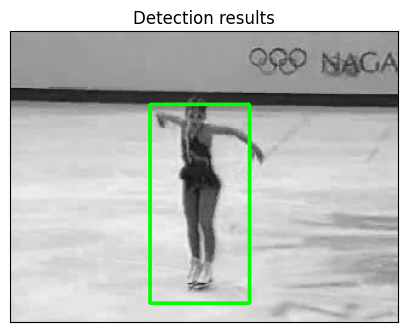

Frame 15


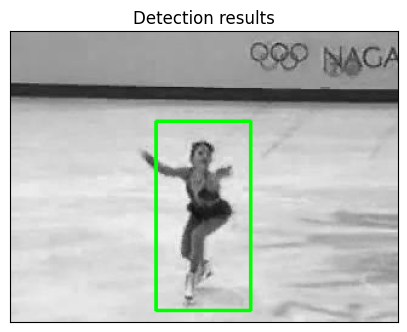

Frame 30


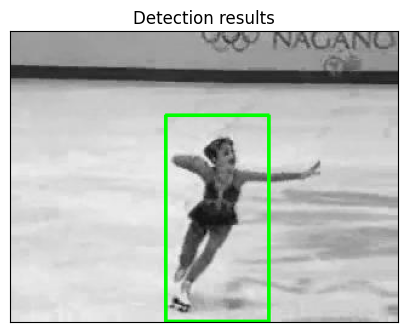

Frame 45


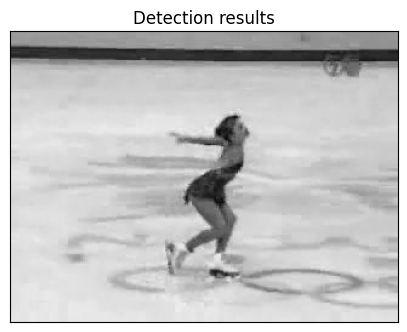

Frame 60


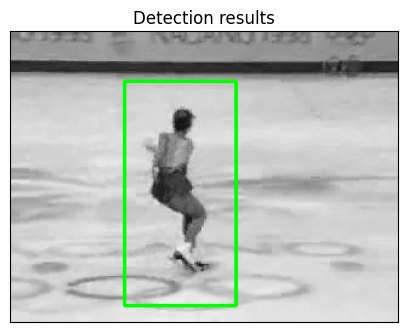

Frame 75


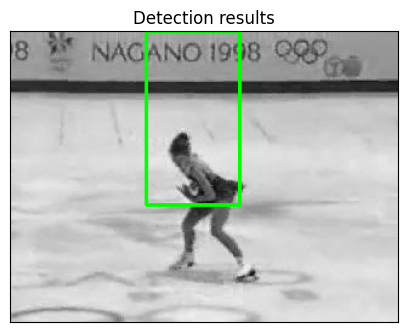

Frame 90


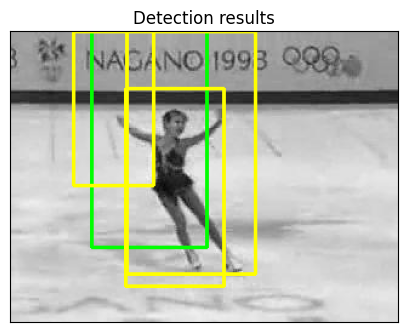

Frame 105


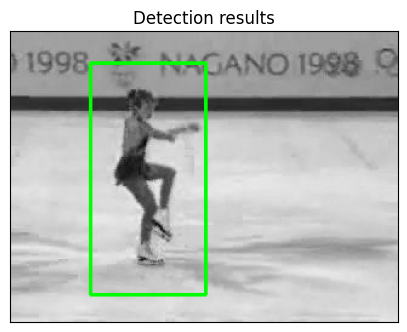

Frame 120


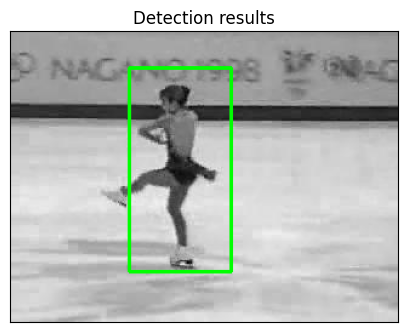

Frame 135


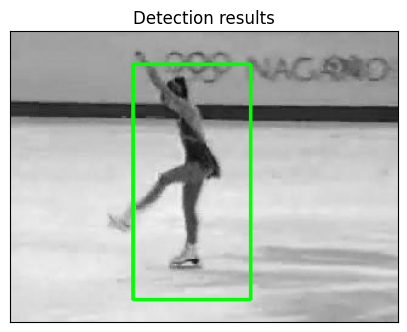

Frame 150


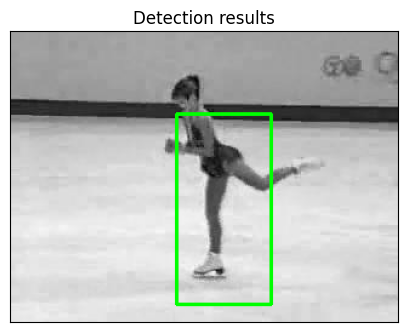

In [91]:
# 3. Display your images here
########################
# YOUR CODE HERE
TIME_INTERVAL = 1 # s
# get fps 
video = cv.VideoCapture(file_path)
fps = video.get(cv.CAP_PROP_FPS)
for i in range(0, len(outputs), int(fps*TIME_INTERVAL)):
    print(f'Frame {i}')
    plt.figure(figsize=(5, 5))
    plt.imshow(cv.cvtColor(outputs[i][0], cv.COLOR_BGR2RGB))
    plt.title('Detection results')
    plt.xticks([])
    plt.yticks([])
    plt.show()
########################
    

## 2 Tracking - Particles Filter

A **particles filter** is an object tracking algorithm which try to ***estimate*** the real position of an object approximating its position in the search space (i.e. image space) using a set of particles. A particle has two properties:
 
    - A state: An estimation of the quantity being tracked, in our case it will be a tuple(x, y) that represent the possible location of the object in the image space.
    - A weight: A probability that the particle is at the correct location of the object being tracked
    
The goal of the filter is to estimate the probability density function of the quantity being tracked over the whole search space. The set or particles is an approximation of this probability density function. When there are a lot of particles in a given region, the probability of the object being there is high. 
To estimate this distribution the algorithm uses Monte Carlo techniques and **approximate** this quantity. There is a total of three steps required to implement a particles filter:
 
1. Perturbate: Given a set of particles, the state is slightly perturbed in order to explore the neighbourhood of each particle. This perturbation is generally drawn from a gaussian distribution.
2. Reweight: The particle's weight are updated in this step. Given a set of measurements (*i.e. perturbed particles*) a similarity metric is computed between the measurements and the object model (*i.e. template*). Particle with high similarity will have a large weight (*i.e. the measurement looks very much like the object*) whether a particle with low similarity will be assigned a small weight (*i.e. the measurement does not look like the object*). The reweighting step adapts the estimation of the probability density function of the quantity being tracked.
3. Resample: The set of particles is updated by sampling in the previous collection of particles using the newly estimated probability density function. Since particles similar to the object have a higher chance to be chosen, the new set of particles should have states located on the actual object.
 
In the following section you will implement these three steps from scratch with the help of the class `ParticleFilterInterface` from file `utils.py`. This class has the following members that will be used in the different methods.
 
- `self.model`: The template of the object being tracked, np.ndarray
- `self.search_space`: The dimensions of the search space, tuple
- `self.n_particles`: The total number of particles used to estimate the distribution, int
- `self.state_dims`: The number of component of each state, int (*i.e. 2 in our case, x/y*), tuple
- `self.sigma_perturbation`: Standard deviation of the perturbation applied to the particles, float
- `self.sigma_similarity`: Standard deviation of the residual error used when computing similarity, float
- `self.alpha`: Blending coefficient used during model adaptation phase, float
- `self.particles`: Collection of particles states stored as 2D array, first column is x, second is y, np.ndarray
- `self.weights`: Distribution estimation, 1D array
- `self.state`: Current best estimation of the object position, np.ndarray
- `self.indexes`: List of index for each particles, nd.array
 



### 2.1 Step 1 : Perturbation (15 pts)
 
In the following cell, two functions need to be implemented to make the tracker work. The methods are: `_initialize_particles` and `perturbate_impl`.
 
The first one, is responsible to initialize each particle's state and weight respectively. Particle's states are stored into a 2D array of dimensions **(#Particles, #States)**, where the first column correspond to the **x** coordinate in the image space the second column is the **y** coordinate. At initialization, each component of the states are uniformly sampled from the search space dimensions (*i.e. image dimensions*).
 
Particles' weights are stored into a 1D array of dimension **(#Particles,)**. Each weight represents the probability of the particle being at the real location of the tracked object. At initialization, particles are equiprobable with a probability of $\frac{1}{\#Particles}$. Moreover the weights need to represent a valid probability distribution function and, therefore, they have to sum to one.
 
The second method is responsible to add perturbation on the particle state. Each perturbation is sampled from a gaussian distribution defined as $\mathcal{N}\left(0, \sigma_{p}^2 \right)$. This perturbation is responsible for exploring the neighbourhood of each particle by randomly moving around.
 
**QUESTION**
 
In the following cell, implement the methods `_initialize_particles` and `perturbate_impl`.


In [ ]:
class ParticleFilterStepOne(ParticleFilterInterface):
    
    def __init__(self,
                 model,
                 search_space,
                 n_particles,
                 state_dims,
                 sigma_perturbation=10.0,
                 sigma_similarity=20.0,
                 alpha=0.0,
                 update_rate=10):
        """
        Constructor
        :param model:         Template image to be tracked (numpy.ndarray)
        :param search_space:  Possible size of the search space (i.e. image size)
        :param n_particles:   Number of particle used to perform tracking
        :param state_dims:    State space dimensions (i.e. number of parameters
                              being tracked)
        :param sigma_perturbation: How much each particle will be perturbated, float
        :param sigma_similarity:  Similarity residual distribution
        :param alpha:         Blending factor for model adaptation, float
        :param update_rate:   Frequency at which the model will be updated, int
        """
        super(ParticleFilterStepOne, self).__init__(model,
                                                    search_space,
                                                    n_particles,
                                                    state_dims,
                                                    sigma_perturbation,
                                                    sigma_similarity,
                                                    alpha)
        self.state = None
        self.update_rate = update_rate
        self._initialize_particles()
        self._check_particle_dims(init=True)
        self._check_weights()
        
    def _initialize_particles(self):
        """
        Initialize each particle state by sampling uniformly the whole serch space. Plus the each weight
        associated to a particles is initialized with a uniform probability:
        """
        
        ########################
        # YOUR CODE HERE
        ########################
        
        
        
        return
        
    def update(self, frame):
        """
        Update particle filter for a new frame
        :param frame: New frame in the tracking sequence
        :return:  Best state (i.e. estimated position
        """

        # Step 1: Perturbation
        self.perturbate()
        
        # Step 2:Other steps goes here
        # ...
        
        self.state = self.current_state()
        return self.state
    
    def perturbate_impl(self):
        """ Perturbate particles with random noise """
        
        ########################
        # YOUR CODE HERE
        ########################
        
        
        return 

The next cell creates a tracker that runs the initialization step, then displays the current particle state at that time.
 
On the left side is your state initialization and on the right side is one possible solution which should be close to the one you have. It is there as a reference.

**QUESTION** 

Why is the solution not exactly the same as the reference?
 

In [ ]:
# Load test image
path = os.path.join('..','data', 'particles_filter', 'frame000.jpg')
frame = cv.imread(path)

# Define model
miny = 175
maxy = miny + 129
minx = 321
maxx = minx + 104
model = frame[miny:maxy, minx:maxx]
# Create particle filter
pf = ParticleFilterStepOne(model=model,
                           search_space=frame.shape[:2],
                           n_particles=200,
                           state_dims=2)
# Draw particle's state
canvas = pf.draw_particles(np.copy(frame))
canvas_true = cv.imread(os.path.join('..','data', 'particles_filter', 'intialized_particles.jpg'))

fig, ax = plt.subplots(1, 2, figsize=(12, 7))
display_image(canvas, axes=ax[0])
ax[0].set_title('Your initialization')
display_image(canvas_true, axes=ax[1])
ax[1].set_title('Expected behaviour')

**Your answer**

In the next cell, the tracker function `update` is called, it applies the first step of the tracking process. Meaning the particles will have a new state (*i.e. position*), to highlight this, the new particles are drawn in **red**. If it is **NOT** the case, check your code!

 
**QUESTION**

**Comment** on what you observe, does the particle state change ? Is the perturbation somehow what is expected ? How could you check that the implementation of the perturbation is correct? 

In [ ]:
# Apply first step of tracking
pf.update(frame)

# Draw particles, should have new position
canvas_perturbated = pf.draw_particles(np.copy(canvas), color=(0, 0, 255))
display_image(canvas_perturbated);

**Your answer**

### 2.2 Step Two : Reweighting (15 pts)

The reweighting function performs two steps:
    
1. Measure the similarity between the image patch centered at every particle state and the object model.
2. Update the weights probability distribution according the measured similarity

**QUESTION** 

In the next cell, complete the implementation of the similarity function. To measure the similarity between two samples `x` and `y`, first the Mean Squared Error is computed then it is assumed that it follows a normal distribution in the form of N(0, sigma):

$$
\begin{align}
    r &= \frac{1}{N} \sum_{i=0}^{N} \left(x_i - y_i\right)^{2}, \quad N = 3\cdot H \cdot W \\
    s &= \exp(-\frac{r}{2\sigma^{2}})
\end{align}
$$

In [ ]:
def similarity_fn(x, y, sigma):
    """
    Compute similarity between `x` and `y` assuming the residual difference
    follow a gaussian distribution N(0, sigma).
    Special case, when the shape of `x`/`y` are not the same/empty it must return a similarity of 0.0
    :param x: First image
    :param y: Second image to compare
    :param sigma: Standard deviation of the residual differences
    :return: Scalar value, similarity between `x` and `y`
    """
    sim = 0.0
    
    
    ########################
    # YOUR CODE HERE
    ########################
    return sim

In [ ]:
# Test your similarity_fn
patch1 = np.copy(model)
patch2 = frame[miny+5:maxy+5, minx+5:maxx+5]
patch3 = np.asarray([])

msg = 'Something is wrong with your similarity function, check you math'
sim_1 = similarity_fn(patch1, patch1, sigma=40.0)
print('Similarity between the same patch: {:.2f}'.format(sim_1))
assert np.round(sim_1, 2) == 1.00, msg
sim_2 = similarity_fn(patch1, patch2, sigma=40.0)
print('Similarity between two different patches: {:.2f}'.format(sim_2))
assert np.round(sim_2, 2) == 0.70, msg
sim_3 = similarity_fn(patch1, patch3, sigma=40.0)
print('Similarity between two different size patches: {:.2f}'.format(sim_3))
assert np.round(sim_3, 2) == 0.00, msg

**QUESTION** 

In the next cell, implement the `reweight_impl` function responsible to update the probability distribution of the particles. The following steps are required

- Extract patches of the frame centered at the particle's state
- Compute similarity between the `model` and every patches
- Normalize the `weights` to have a valid probability distribution

In [ ]:
class ParticleFilterStepTwo(ParticleFilterStepOne):
    
    def __init__(self,
                 model,
                 search_space,
                 n_particles,
                 state_dims,
                 sigma_perturbation=10.0,
                 sigma_similarity=20.0,
                 alpha=0.0,
                 update_rate=10):
        """
        Constructor
        :param model:         Template image to be tracked (numpy.ndarray)
        :param search_space:  Possible size of the search space (i.e. image size)
        :param n_particles:   Number of particle used to perform tracking
        :param state_dims:    State space dimensions (i.e. number of parameters
                              being tracked)
        :param sigma_perturbation: How much each particle will be perturbated, float
        :param sigma_similarity:  Similarity residual distribution
        :param alpha:         Blending factor for model adaptation, float
        :param update_rate:   Frequency at which the model will be updated, int
        """
        super(ParticleFilterStepTwo, self).__init__(model,
                                                    search_space,
                                                    n_particles,
                                                    state_dims,
                                                    sigma_perturbation,
                                                    sigma_similarity,
                                                    alpha)
        
    def update(self, frame):
        """
        Update particle filter for a new frame
        :param frame: New frame in the tracking sequence
        :return:  Best state (i.e. estimated position
        """
        self.perturbate()
        self.reweight(frame)
        # Other steps goes here
        # ...
        
        self.state = self.current_state()
        return self.state
    
    def reweight_impl(self, frame):
        """
        Update particle's weight for the current frame
        :param frame: New frame in the tracking sequence
        """
        
        ########################
        # YOUR CODE HERE
        ########################
            
        
        return

The next cell will instanciate a tracker and display the evolution of the weights for a single step of tracking. 

**Question**

**Comment** on what you observe, is it following what you're expecting ? What does a high score mean ? What is the expected range of the weights ?

**Your answer**

In [ ]:
# Create particle filter
pf = ParticleFilterStepTwo(model=model,
                           search_space=frame.shape[:2],
                           n_particles=200,
                           state_dims=2)
# Save initial weights
w_init = np.copy(pf.weights)

# Update tracker using current frame
pf.update(frame)

# Show updated weights
w = pf.weights

plt.figure()
plt.plot(w_init)
plt.plot(w)
plt.title('Weights change after `Reweight` step')
plt.legend(['Weights initialization',
            'Updated weights'])
plt.show()

### 2.3 Step Three : Resample (15 pts)

The purpose of this step is to resample a new set of particles using the current estimation of the particle's distribution (*i.e. weights*). Remember, the particles have been previously perturbated and reweighted, therefore the distribution is different. The new set of particles new to be sampled using the updated probability distribution, meaning particles with high probability will be selected more often then the one with small weight.

Once a new set of particles have been sampled, you need to be sure that the state is still valid, therefore a clipping step is added in order to ensure the state remain in the image space.

**QUESTION**
In the following class, implement the resampling scheme inside the function `resample_impl`. 

*Hint*: You may want to use np.random.choice in your implementation to perform this resampling step.

In [ ]:
class ParticleFilterStepThree(ParticleFilterStepTwo):
    
    def __init__(self,
                 model,
                 search_space,
                 n_particles,
                 state_dims,
                 sigma_perturbation=10.0,
                 sigma_similarity=20.0,
                 alpha=0.0,
                 update_rate=10):
        """
        Constructor
        :param model:         Template image to be tracked (numpy.ndarray)
        :param search_space:  Possible size of the search space (i.e. image size)
        :param n_particles:   Number of particle used to perform tracking
        :param state_dims:    State space dimensions (i.e. number of parameters
                              being tracked)
        :param sigma_perturbation: How much each particle will be perturbated, float
        :param sigma_similarity:  Similarity residual distribution
        :param alpha:         Blending factor for model adaptation, float
        :param update_rate:   Frequency at which the model will be updated, int
        """
        super(ParticleFilterStepTwo, self).__init__(model,
                                                    search_space,
                                                    n_particles,
                                                    state_dims,
                                                    sigma_perturbation,
                                                    sigma_similarity,
                                                    alpha)
        
    def update(self, frame):
        """
        Update particle filter for a new frame
        :param frame: New frame in the tracking sequence
        :return:  Best state (i.e. estimated position
        """
        self.perturbate()
        self.reweight(frame)
        self.resample()
        # Other steps goes here
        # ...
        
        self.state = self.current_state()
        return self.state
    
    def resample_impl(self):
        """ 
        Resample a new set of particle based on update weight distribution and previously 
        perturbated particles
        Hint: You may want to use `np.random.choice` here
        """
        
        ########################
        # YOUR CODE HERE
        ########################
        
        
        return

The next cell creates a tracker and performs the three steps of the particle filter (*The update step is performed twice in order to emphasis the impact of the resampling step*). It shows the states of the particles at initialization (*i.e. in green*) and after resampling (*i.e. in red*). The last figure shows the expected behaviour.

**QUESTION** 

**Comment** on what you observe, how the particle states change ? Why does it converge to the object ?

**Your answer**

In [ ]:
# Create particle filter
pf = ParticleFilterStepThree(model=model,
                             search_space=frame.shape[:2],
                             n_particles=200,
                             sigma_perturbation=20.0,
                             sigma_similarity=15.0,
                             state_dims=2)
# Save initial particle position
initial_particles = pf.draw_particles(np.copy(frame))

# Update tracker
pf.update(frame)
pf.update(frame)

# Draw particle's state after resampling
resampled_particules = pf.draw_particles(np.copy(frame))
resampled_true = cv.imread(os.path.join('..','data', 'particles_filter', 'resampled_particles.jpg'))

fig, ax = plt.subplots(3, 1, figsize=(14, 10))
display_image(initial_particles, axes=ax[0])
ax[0].set_title('Initial particles state')
display_image(resampled_particules, axes=ax[1])
ax[1].set_title('Resampled particles state')
display_image(resampled_true, axes=ax[2])
ax[2].set_title('Expected behaviour')

Now, you will use the `transform_video_file` function you've coded earlier to track Romney's face in the first 300 frames of the video `videos/pres_debate.avi`. The initialized particle filter will pass to the `particles_filter_fn` through the params variable. It will be packed in a dictionnary with the key set to 'tracker'.

**QUESTION**

**Complete** the implementation of the tracking function. 

*Hint*: Too draw the state of the tracker, you can use the method `visualize_filter` of the particle filter

In [ ]:
def particles_filter_fn(frame, params):
    """
    Run one step of particles filter and draw tracking results on top of the image
    :param params: dict instance with the following entries: 
                    'tracker': Tracker instance
    :return: frame with detected area
    
    """
    res = None
    ########################
    # YOUR CODE HERE
    ########################
    return res

In [ ]:
# Load face model
model = cv.imread(os.path.join('..', 'data', 'particles_filter', 'face_model.jpg'))
# Create particle filter
pf = ParticleFilterStepThree(model=model,
                             search_space=(720, 1280),
                             n_particles=200,
                             sigma_perturbation=10.0,
                             sigma_similarity=10.0,
                             state_dims=2)

# Set parameters
params = {'tracker': pf}

# Call tracking function on video
video_path = os.path.join('..', 'data', 'videos', 'pres_debate.avi')
results = transform_video_file(video_path, particles_filter_fn, params=params, n_frame=300)

**QUESTION** 

In the next cell, display the tracking results every 30 frames.

**Comment** on what you observe, is the tracking good ? What happen when he turns his head ? Is the object model good enough ? What happened if you run the detection from scratch several times?

**Your answer**

In [ ]:

########################
# YOUR CODE HERE
########################
        

### 2.4 Step Four : Model adaptation (15 pts)

Having a fixed model of the object is not optimal when there is movement (*i.e. out of plane rotation*). Therefore in the next section, a simple model adaptation will be implemented into our particles filter.

The model will not be updated every frame to ensure a smooth transition in term of appearance. The update rate is controled with the `update_rate` parameter in the constructor. The model adaptation consists of a linear interpolation between the patch located at the current best position estimation (*i.e. self.state*) and the previous model.

$$
M_{new} = \alpha \cdot P_{best} + \left(1 - \alpha \right) M_{old}
$$

where $\alpha$ control the amount of blending between the two patches, $P_{best}$ is the patch around the current estimation of the object position and $M_{old}$ is the actual model of the object. 

**QUESTION**

In the next cell, implement the model adaptation in the method `update_model()`.

In [ ]:
class ParticleFilterStepFour(ParticleFilterStepThree):
    
    def __init__(self,
                 model,
                 search_space,
                 n_particles,
                 state_dims,
                 sigma_perturbation=10.0,
                 sigma_similarity=20.0,
                 alpha=0.0,
                 update_rate=10):
        """
        Constructor
        :param model:         Template image to be tracked (numpy.ndarray)
        :param search_space:  Possible size of the search space (i.e. image size)
        :param n_particles:   Number of particle used to perform tracking
        :param state_dims:    State space dimensions (i.e. number of parameters
                              being tracked)
        :param sigma_perturbation: How much each particle will be perturbated, float
        :param sigma_similarity:  Similarity residual distribution
        :param alpha:         Blending factor for model adaptation, float
        :param update_rate:   Frequency at which the model will be updated, int
        """
        super(ParticleFilterStepTwo, self).__init__(model,
                                                    search_space,
                                                    n_particles,
                                                    state_dims,
                                                    sigma_perturbation,
                                                    sigma_similarity,
                                                    alpha)
        
    def update(self, frame):
        """
        Update particle filter for a new frame
        :param frame: New frame in the tracking sequence
        :return:  Best state (i.e. estimated position
        """
        self.perturbate()
        self.reweight(frame)
        self.resample()
        self.state = self.current_state()
        self.frame_counter += 1
        if self.alpha > 0.0 and (self.frame_counter % self.update_rate) == 0:
            self.update_model(frame)
        return self.state
    
    def update_model(self, frame):
        """
        This function perform a `model update using the current best estimation of
        the object position (i.e. state) and linearly blend the previous model and
        the patch at the best state:
          model_new = alpha * best_patch + (1 - alpha) * model_old
        It also perform so sanity check to ensure the dimensions of the model are
        valid.
        :param frame: Current frame
        """
        
        ###############
        # YOUR CODE HERE
        ###############

        return 

**QUESTION** 

Now that you have a working object tracker, apply the same methodology to track Romney's left hand and again display every frames that are a multiple of 30. You can use the following patch as model *x=520, y=375, w=104, h=129*.

Reuse the same structure has what we've done when tracking his face.

**Discuss** the influence of the various parameters (i.e. Number of particles, sigma_perturbation, sigma_similarity, alpha, update_rate, ...) on the performance of the tracking. 


**Your answer**

In [ ]:

###############
# YOUR CODE HERE
###############


## 3 Face Tracking

Up to now, the frames of the video were considered as single image having no relationship between them. However, this is not the best approach: the correlation between two consecutive frames is large, since the image will displace or change in the next frame with respect to the previous one only by few pixels. We can rely on this to build a smarter detector. 

The case study for the next sections will be face tracking. The task is to provide a bounding box where the face is located. A number of methods will be analysed and benchmarked against each other. The baseline will be established with a standard face detector based on [Viola, Jones](https://www.cs.cmu.edu/~efros/courses/LBMV07/Papers/viola-cvpr-01.pdf) work (*i.e. no tracking*). Then, you will compare it against the tracking algorithms.

The methods to use and compare are the following:

- Frame-wise face detection (Baseline)
- Tracking: 'MIL', 'KCF', 'TLD', 'MedianFlow', 'Mosse'

For comparison, you will be asked  to implemented the following metrics:

- Euclidean distance between center's bounding box
- Intersection over Union
- Computation time

Your first task is to implement the preprocessing function that will be applied on every frame before actually doing the tracking. You can apply any transformation you want to each frames.

In [ ]:
# Load all images
def preprocessing_fn(image, params):
    """
    Apply preprocessing on a given image.
    
    :param image: Image to preprocess
    :param params: Extra parameters
    :return: Preprocessed image
    """
    # Indentity function, but you can do whatever you need to
    return image

file_path =  os.path.join('..','data', 'videos', 'speaker.avi')
images = transform_video_file(file_path, preprocessing_fn, n_frame=350)
print('Video contains a total of {} frames'.format(len(images)))

### 3.1 Face Detection (1pt)

The detection baseline is established using an instance of `cv::CascadeClassifier` which implements the approach proposed by Viola & Jones for object detection. 

Your task is to complete the implementation of the `detection_fn` which, given an instance of a classifier and an image, return the bounding box where the face is located. More information about the detector can be found in the [doc](https://docs.opencv.org/3.4.4/d1/de5/classcv_1_1CascadeClassifier.html#ab3e572643114c43b21074df48c565a27).

Be sure to implement a solution to deal with the situation where multiple boxes are returned by the classifier. The function must return **ONLY** one bounding box.

In [ ]:
def detection_fn(detector, image):
    """
    Run face detection on a given `image` with an instance of CascadeClassifier
    
    :param detector: CascadeClassifier instance
    :param image: Frame on which to run detection
    :return: bounding box if any or None
    """
    bbox= None
    #######################################
    # YOUR CODE HERE
    #######################################
    return bbox

The code in the following cell will test your `detection_fn` and display the outcome for the first four frames of the video.

In [ ]:
# Load face detector
fpath = os.path.join('..', 'data', 'haarcascade_frontalface_alt2.xml')
fdet = cv.CascadeClassifier(fpath)
assert fdet.empty() is not True

# Detect 
detection_out= []
for img in images[:4]:
    bbox = detection_fn(fdet, img)
    detection_out.append(bbox)
    
# Display
fig, ax = plt.subplots(2, 2, figsize=(17, 9))
for k, box in enumerate(detection_out):
    # Draw rectangle
    x, y, w, h = box
    im = cv.rectangle(images[k].copy(), (x, y), (x + w -1, y + h -1), (255, 0, 0), 3, lineType=cv.LINE_AA)
    # Display
    r = k // 2
    c = k % 2
    display_image(im, axes=ax[r][c])
    ax[r][c].set_title('Detection at frame {}'.format(k))
    ax[r][c].set_xticks([])
    ax[r][c].set_yticks([]);    

### 3.2 Face Tracking (2pts)

Similar to what you have done before, you will have to complete the `tracking_fn` that will perform the tracking step. Given one instance of `cv::Tracker` [(doc)](https://docs.opencv.org/3.4.4/d0/d0a/classcv_1_1Tracker.html) and a  input image, the function will return the bounding box where the object (*i.e. face*) is located.

Again, be sure to **ONLY** one bounding box.

In [ ]:
def tracking_fn(tracker, image):
    """
    Perform tracking on a given image.
    
    :param tracker: Tracker instance
    :param image: Image on which to run tracker
    :return: Bounding box if any
    """
    bbox = None
    #######################################
    # YOUR CODE HERE
    #######################################
    return bbox 

The following cell will test your `tracking_fn` in the same way as what we did earlier b traking the first four frames of the video and displaying the results. 

In [ ]:
# Create tracker
tracker = create_face_tracker(name='KCF')
tracker.init(images[0], (551, 121, 153, 153))

# Detect 
tracking_out=[]
for img in images[:4]:
    bbox = tracking_fn(tracker, img)
    tracking_out.append(bbox)
           
# Display
fig, ax = plt.subplots(2, 2, figsize=(17, 9))
for k, box in enumerate(tracking_out):
    # Draw rectangle
    x, y, w, h = box
    x = int(x); y=int(y); w=int(w); h=int(h)
    im = cv.rectangle(images[k].copy(), (x, y), (x + w -1, y + h -1), (0, 255, 0), 3, lineType=cv.LINE_AA)
    # Display
    r = k // 2
    c = k % 2
    display_image(im, axes=ax[r][c])
    ax[r][c].set_title('Tracking at frame {}'.format(k))
    ax[r][c].set_xticks([])
    ax[r][c].set_yticks([]);    

### 3.3 Comparison

#### 3.4.1 Metric

The performance of a given tracker will be assessed with the following metrics:

- Intersection over Union
- Distance between center's bounding boxes
- Execution time

##### 3.4.1.1 Intersection over Union (1pt)

Your task is to complete the implementation of the `iou_metric` function. The function will return the *Intersection over Union* given two bounding boxes, namely `box_a` and `box_b`.

You can find the metric as the Jaccard index https://en.wikipedia.org/wiki/Jaccard_index. Feel free to modify the implementation below to adapt it to your function output.

In [ ]:
def iou_metric(box_a, box_b):
    """
    Compute the Intersection over Union (IoU) between two bounding boxes (x, y, w, h)
    
    :param box_a: First bounding box
    :param box_b: Second bounding box
    :return: Intersction over Union
    """
    
    
    
    iou = 0.0
    #######################################
    # YOUR CODE HERE
    #######################################
    
    
    return iou

In [ ]:
# Usage + sanity check
IoU = iou_metric(box_a=[39, 63, 164, 49], box_b=[40, 63, 165, 49])
print('Intersection over Union: {:.3f}'.format(IoU))
assert round(IoU, 3) == 0.982, 'Somehting went wrong at your implementation of the `iou_metric` function'

##### 3.4.1.2 Center's distance (1pts)

Complete the `center_metric` function that compute the euclidean distance between two bounding box centers, define as:

$$
d_i = \left|\left| c_i^A - c_i^B \right|\right|
$$

where `A` and `B` are the two bounding boxes (*i.e. detection + ground truth*)


In [ ]:
def center_metric(box_a, box_b):
    """
    Compute the Euclidean distance between two given bounding boxes
    
    :param box_a: First bounding box
    :param box_b: Second bounding box
    :return: Distance
    """
    
    d = 0.0
    #######################################
    # YOUR CODE HERE
    #######################################
    return d
    

In [ ]:
# Usage + sanity check
dist = center_metric(box_a=[39, 63, 164, 49], box_b=[40, 63, 165, 49])
print('Distance: {:.3f}'.format(dist))
assert round(dist, 3) == 1.500, 'Somehting went wrong at your implementation of the `iou_metric` function'

##### 3.4.1.3 Execution time (1pt)

The function `time_metric` will measure the execution time of a given function defined in `processing_fn`. Its signature must be `processing_fn() -> Any`.
If the `processing_fn` return some values, they will be passed through the `time_metric` function. Therefore the return value is a tuple containing the execution time in first position and anything returned by `processing_fn` in the second position.

In [ ]:
def time_metric(processing_fn):
    """
    Measure the execution time of a given function (i.e. lambda function)
    
    :param processing_fn:  Lambda function to be timed
    :return: Execution time in milli-seconds
    """
    ex_time = 0
    retval = None
    #######################################
    # YOUR CODE HERE
    #######################################
    
    return ex_time, retval
    

The `time_metric` function can be used as follow:


In [ ]:
# Using user define function with proper prototype
def wasting_time_func():
    _time.sleep(0.75)
    return 'Done'
    
# Call metric
dt, ret = time_metric(wasting_time_func)
print('User-defined function took: {:.3f} ms, with return value {}'.format(dt, ret))

In [ ]:
# Using lambda function 
dt, ret = time_metric(lambda: _time.sleep(0.5))
print('Lambda function took: {:.3f} ms'.format(dt))

#### 3.4.2 Load Ground Truth (2pts)

The true bounding boxes are stored into the `data/videos/speaker_gt.txt` text file. Each line contains the true bounding box for the corresponding frame.

Your task is to complete the `load_ground_truth` that parses the file and return a list of boxes.

In [ ]:
def load_ground_truth(filename):
    """
    Load all detection stored into a given file
    
    :param filename: Path to the text file storing the ground truth
    :return: List of bounding boxes
    """
    bboxes = []
    ###########################
    # YOUR CODE HERE
    ###########################
    
    return bboxes

Load every face bounding boxes into a list

In [ ]:
# Load ground truth
fname = os.path.join('..', 'data', 'videos', 'speaker_gt.txt')
gt_bbox = load_ground_truth(filename=fname)
print('There is a total of {} bounding boxes'.format(len(gt_bbox)))


#### 3.4.3 Experimental setup (2pts)

In the `run_experiment` function, given a list of pair `{Image, Ground truth}`, it will perform the tracking/detection on all images and run the various *metrics* that have been implemented earlier. 

The results for a **single** frame will be stored into a dictionary with the following entries:

- `bbox` will contain the detected region
- `metrics` will contain all the metrics computed during the experiment. The metrics are stored in a `tuple` ordered as : `IoU, Distance, Time`


The next cells run the experiment with the `detection_fn` in order to establish the baseline. Later, on the tracking results, all the metrics will be compared against it.

In [ ]:
def run_experiment(images, true_bbox, tracking_fn):
    """
    Run a given detection/tracking function on a list of images.
    
    :param images: List of consecutive images to processed (already preprocessed)
    :param bboxes: List of true bounding boxes (Ground truth)
    :param tracking_fn: Function running detection/tracking for ONE frame
    :return: List of dictionnaries for each frames holding detected bounding box if any and the various metrics
    """
    metrics = []
    for img, gt_bbox in zip(images, true_bbox):
        # Run metrics + tracking
        dt, bbox = time_metric(lambda: tracking_fn(img))        
        iou = iou_metric(bbox, gt_bbox)
        dist = center_metric(bbox, gt_bbox)
        # Accumulate results
        metrics.append({'bbox': bbox, 'metric': (iou, dist, dt)})
    # Done
    return metrics

# Run detection, no tracking
detection_exp = run_experiment(images=images, true_bbox=gt_bbox, tracking_fn=lambda x: detection_fn(fdet, x))

Your task is to run the same experiment (*i.e. `run_experiment`*) for all the selected trackers. To instantiate the tracker using its name, you have to use the function `create_face_tracker(str) -> cv::Tracker`.

For the initialisation of the tracker, you can use the region: `(551, 121, 175, 175)`.

In [ ]:
# List of tracker to use
trackers_name = ['MIL', 'KCF', 'TLD', 'MedianFlow', 'Mosse']
# Run experiments for each tracker
trackers_exp = {}
for name in trackers_name:
    
    ###########################
    # YOUR CODE HERE
    ###########################

#### 3.4.4 Results (15pts)

In this section we ask you to display and discuss about the outcome of the tracking experiments. Compare every tracker with the baseline established earlier and discuss what you observed.

Report the following quantities:

- For each metric, plot its value for each frame for each method on the same graph. You should have three plots.
- The `min`, `max`, `mean`, `std` of each metrics for every tracker and the baseline, comment on the values
- Display the detection/tracking of the `best` and the `worst` IoU for each algorithm
- Discuss the performance of each tracker
- Discuss the pros and cons of each metrics
- Investigate each tracker and explain briefly what is the methods used under the hood.


In [ ]:
# Add detection restults
trackers_exp['Det'] = detection_exp

str_info    = 'Metric {} | Mean: {:.2f} | Min: {:.2f} | Max: {:.2f} | Std: {:.2f}'

print("\n****** IoU ******")
plt.figure(figsize=(8, 5))
for key, value in trackers_exp.items():
    IoU = [k['metric'][0] for k in value]
    plt.plot(IoU)
    print(str_info.format(key, np.mean(IoU), np.min(IoU), np.max(IoU), np.std(IoU)))
plt.legend(list(trackers_exp.keys()))
plt.title('Intersection over Union') 


print("\n****** Distance ******")
plt.figure(figsize=(8, 5))
for key, value in trackers_exp.items():
    dist = [k['metric'][1] for k in value]
    plt.plot(dist) 
    print(str_info.format(key, np.mean(dist), np.min(dist), np.max(dist), np.std(dist)))

plt.legend(list(trackers_exp.keys()))
plt.title('Center\'s distance')


print("\n****** Processing time ******")
plt.figure(figsize=(8, 5))
for key, value in trackers_exp.items():
    dt = [k['metric'][2] for k in value]
    plt.plot(dt)    
    print(str_info.format(key, np.mean(dt), np.min(dt), np.max(dt), np.std(dt)))

plt.legend(list(trackers_exp.keys()))
plt.title('Processing time [ms]')